<a href="https://colab.research.google.com/github/kaiu85/llm-workshop/blob/main/Transformers/RAG_DEMO_ALMOST_DONE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieved Augmented Generation using HuggingFace, Mistral-7B, Langchain and Chroma

This is a slightly modified version of this wonderful notebook by Nour Eddine ZEKAOUI: https://github.com/zekaouinoureddine/Adding-Private-Data-to-LLMs/blob/master/notebooks/Ask_Your_Web_Pages_En.ipynb

It shows you, how to use vector databases to efficiently search and query **relevant** external documents to enhance the answers of your LLM based on the content of these documents (i.e., ideally based on **knowledge** and **facts**).

The last part, where the vector database is integrated with the chat history is still a bit sketchy, so if you're getting there today and get stuck, please reach out. Maybe one could even skip the use of langchain and only use Chroma together with the correct prompting...



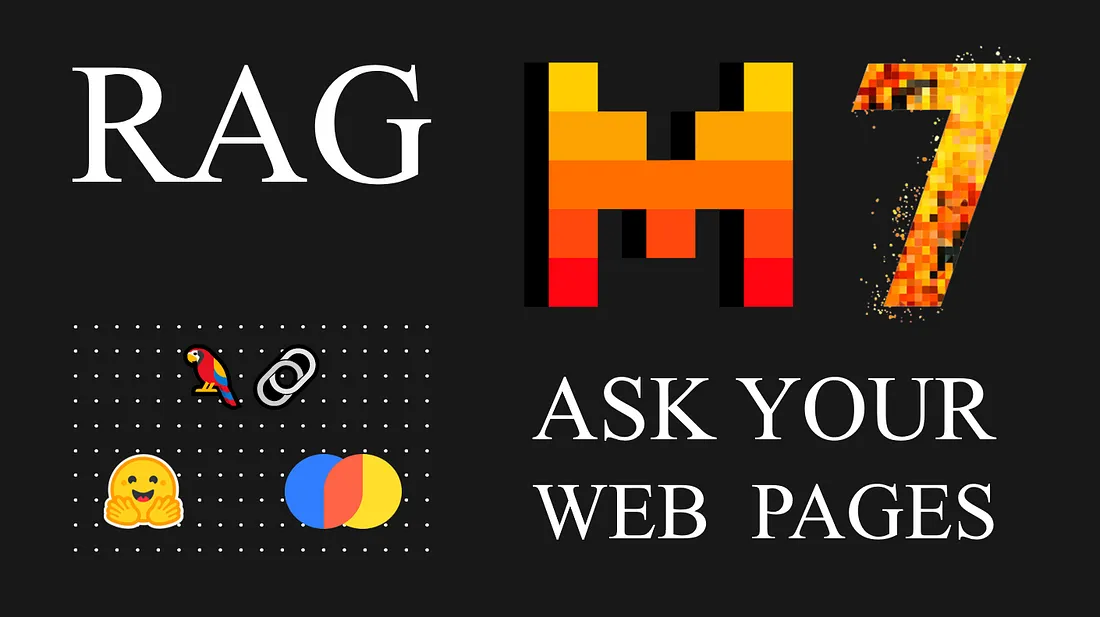

### **Introduction**

How can you augment LLMs with data they weren't trained on? **Retrieval Augmented Generation (RAG)** is the way to go. Let me explain what it means and how it actually works.

Let's say that you've got your own dataset for example documents of text from your company. How can you make **ChatGPT** and other LLMs learn about it and answer questions?

Well this can easily be done in four steps:

1. **Embedding:**
Embed your documents with an embedding model like **text-embedding-ada-002** from OpenAI or **S-BERT**. Embedding a document means transforming its sentences or chunk of words into a vector of numbers. The idea is that sentences that are similar to each other should be close in terms of distance between its vectors and sentences that are different should be further away.

2. **Vector Store:**
Once you've got a list of numbers, you can **store** them in a **vector store** like **ChromaDB**, **FAISS**, or **Pinecone**. A vector store is like a database but as the name says, it **indexes** and **stores** vector embeddings for **fast retrieval** and **similarity search**.

3. **Query:**
Now that your document is embedded and stored, when you ask a specific question to an LLM, it will embed your query and find in the vector store the sentences that are the closest to your question in terms of **cosine similarity** for example.

4. **Answering Your Question:**
Once the closest sentences have been found, they are injected into the prompt and that's it! LLMs are now able to answer specific questions on data that it wasn't trained on, **without any retraining** or **fine-tuning**! How cool is that?

### **Getting Started**

We have not said everything yet; just fasten your seat belts. We will now embark on a high-speed coding journey to demonstrate how you can build a completely **free RAG** system using **open-source** models hosted on the **Hugging Face** Model Hub and code each component in its following architecture:

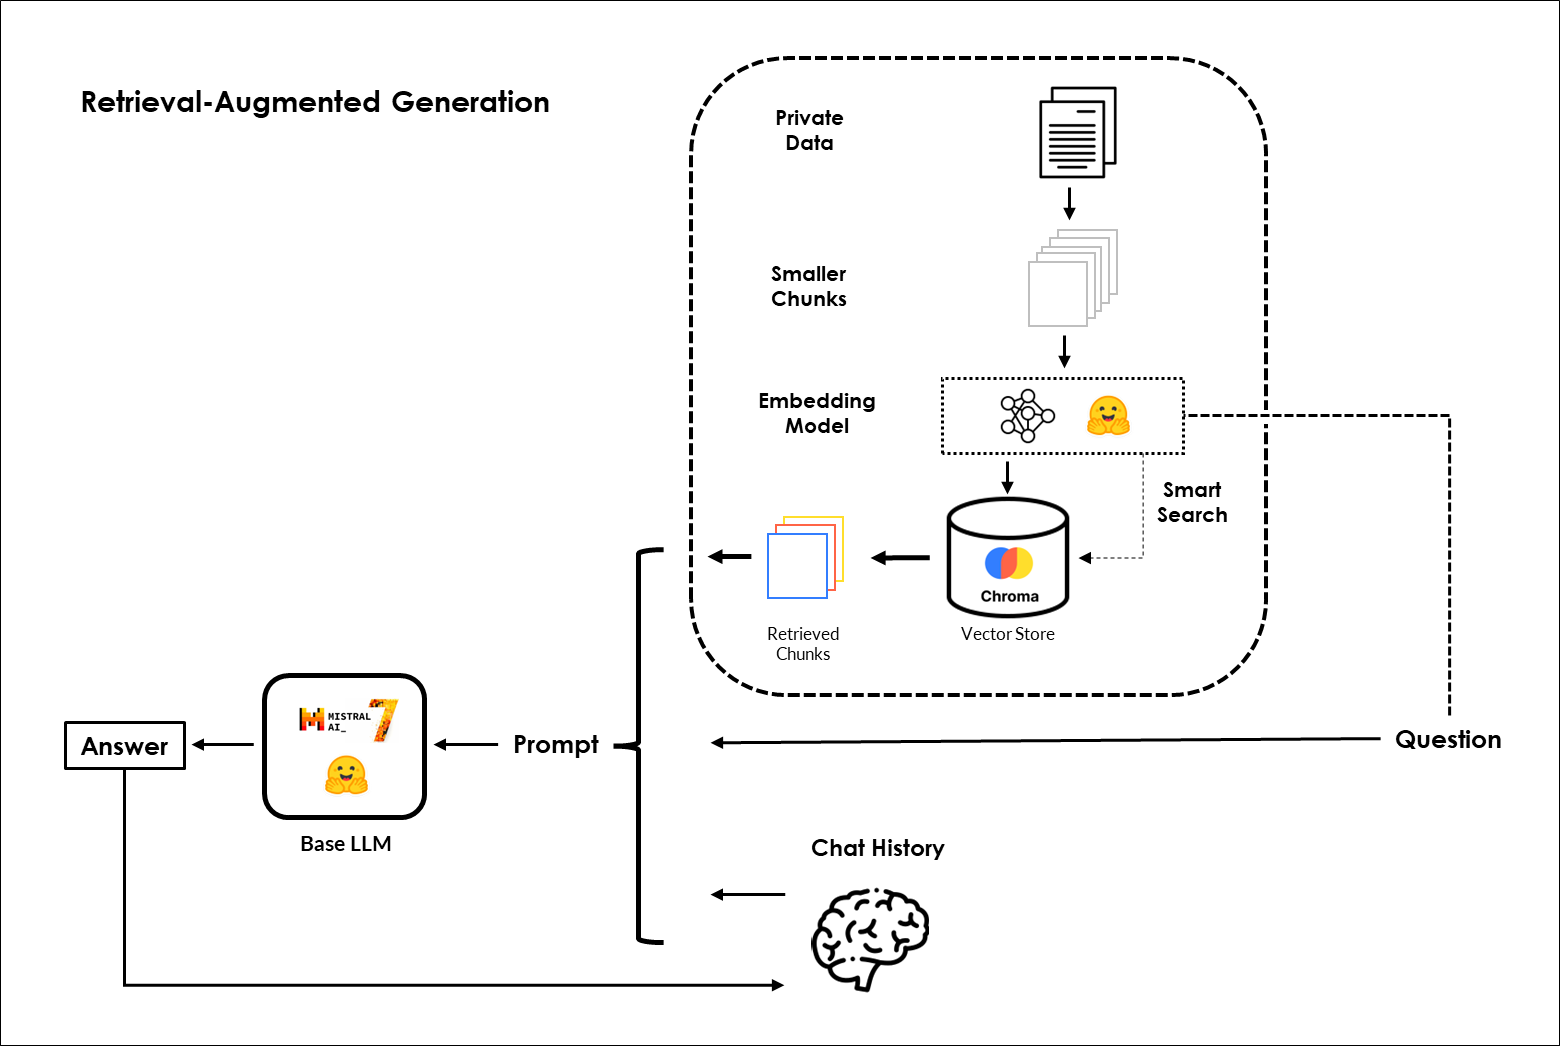

#### Installations

These lines of code are installing several **Python libraries** and **packages** using the **pip** package manager, and the **--quiet** flag is used to reduce the amount of output displayed during the installation process, making it less verbose

In [ ]:
!pip install gradio --quiet
!pip install xformer --quiet
!pip install chromadb --quiet
!pip install langchain --quiet
!pip install accelerate --quiet
!pip install transformers --quiet
!pip install bitsandbytes --quiet
!pip install unstructured --quiet
!pip install sentence-transformers --quiet
!pip install langchain-huggingface --quiet
!pip install langchain-community --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.5/142.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 4.3 MB/s eta 

#### Imports

In the following script, we import a wide range of **libraries** and **modules** for advanced natural language processing and text generation tasks. Essentially, we are setting up an environment for working with language models, including **Hugging Face** models, as well as various tools and utilities for handling and processing text data

We mainly import **PyTorch** for deep learning capabilities and **Gradio** for building interactive ML model interfaces. Additionally, we import modules from the **langchain** library, which include templates for creating prompts, various chain models for language understanding and generation, text embeddings, and document loaders. Our code also integrates the powerful **Transformers** library, which allows for seamless use of **Hugging Face's state-of-the-art models** for a wide range of NLP applications.

In [ ]:
import torch
import gradio as gr

from textwrap import fill
from IPython.display import Markdown, display

from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
    )

from langchain import PromptTemplate
from langchain_huggingface import HuggingFacePipeline

from langchain.vectorstores import Chroma
from langchain.schema import AIMessage, HumanMessage
from langchain.memory import ConversationBufferMemory
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import UnstructuredMarkdownLoader, UnstructuredURLLoader
from langchain.chains import LLMChain, SimpleSequentialChain, RetrievalQA, ConversationalRetrievalChain

from transformers import BitsAndBytesConfig, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, pipeline

import warnings
warnings.filterwarnings('ignore')

#### Base LLM

**Mistral-7b** developed by **Mistral AI** is taking the Open Source LLM landscape by storm. This new open-source LLM outperforms LLaMA-2 on many benchmarks, as illustrated in the following image taken from its paper:

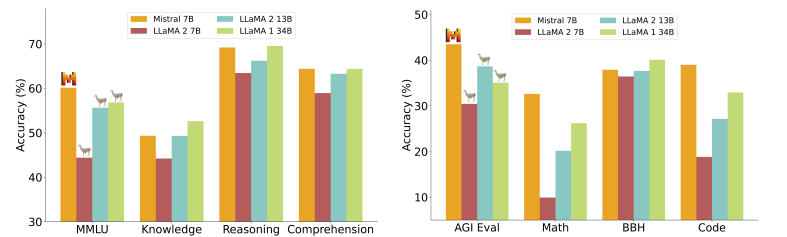

 The following code snippet sets up a **text generation pipeline** using a base LLM, **Mistral-7b** developed by **Mistral AI**, instruct pre-trained language model, configures it with **quantization** settings, **tokenization**, and **generation parameters**, and creates a pipeline that can be used for generating text based on the **Mistral-7b** LLM and configurations. Let's break down what's happening:

* **`quantization_config = BitsAndBytesConfig(...)`**: Here, a **quantization** configuration is defined using the **BitsAndBytesConfig**. Quantization is a technique used to reduce the memory and computation requirements of deep learning models, typically by using **fewer bits**, **4 bits** in our case to represent model parameters.

* **`tokenizer = AutoTokenizer.from_pretrained(...)`**: This line initializes a tokenizer for the **Mistral-7b** model, allowing you to preprocess text data for input to the model.

* **`model = AutoModelForCausalLM.from_pretrained(...)`**: This initializes the pre-trained language **Mistral-7b** model for causal language modeling. The model is configured with various parameters, including the **quantization** **configuration**, which was set earlier.

* **`generation_config = GenerationConfig.from_pretrained(...)`**: A **generation configuration** is created for the model, specifying various generation-related settings, such as the **maximum number of tokens**, **temperature** for **sampling**, **top-p sampling**, and **repetition penalty**.

* **`pipeline = pipeline(...)`**: Finally, a text generation pipeline is created using the **pipeline** function. This pipeline is set up for text generation, and it takes the pre-trained model, tokenizer, and generation configuration as inputs. It's configured to return full text outputs.

In [ ]:
# To accept the Mistral License, you have to authenticate with a huggingface.co token
import os
os.environ["HF_TOKEN"]='' # Get a token at huggingface.co and put it here

In [ ]:
MODEL_NAME = "mistralai/Mistral-7B-Instruct-v0.1"
# MODEL_NAME ="mistralai/Mistral-7B-Instruct-v0.2"
# MODEL_NAME ="meta-llama/Meta-Llama-3-8B"
# MODEL_NAME ="microsoft/Phi-3-mini-4k-instruct"
# MODEL_NAME ="microsoft/phi-1_5"

# Quantization is a technique used to reduce the memory and computation requirements
# of deep learning models, typically by using fewer bits, 4 bits
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
)

# Initialization of a tokenizer for the language model,
# necessary to preprocess text data for input
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
tokenizer.pad_token = tokenizer.eos_token

# Initialization of the pre-trained language model
model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME, torch_dtype=torch.float16,
    trust_remote_code=True,
    device_map="auto",
    quantization_config=quantization_config
)

tokenizer_config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [ ]:
# Configuration of some generation-related settings
generation_config = GenerationConfig.from_pretrained(MODEL_NAME)
generation_config.max_new_tokens = 1024 # maximum number of new tokens that can be generated by the model
generation_config.temperature = 0.7 # randomness of the generated tex
generation_config.top_p = 0 # diversity of the generated text
generation_config.do_sample = True # sampling during the generation process
generation_config.pad_token_id = tokenizer.pad_token_id
# generation_config.repetition_penalty = 1.15 # the degree to which the model should avoid repeating tokens in the generated text

# A pipeline is an object that works as an API for calling the model
# The pipeline is made of (1) the tokenizer instance, the model instance, and
# some post-procesing settings. Here, it's configured to return full-text outputs
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    generation_config=generation_config,
)

**HuggingFacePipeline** is a class that allows you to run Hugging Face models locally. It is used to access and utilize a wide range of pre-trained ML models hosted on the Hugging Face Model Hub. In our case, we will use it within our LangChain environment to interact with Hugging Face models as a **local wrapper**. However, when working with the HuggingFacePipeline, the installation of **xformer** is recommended for more memory-efficient attention implementation. This why we have installed it above!

In [ ]:
llm = HuggingFacePipeline(
    pipeline=pipe,
    )

Let's have some fun! Before connecting our base LLM, **Mistral-7b**, to our private data. First, let's ask it some general questions. Of course, it will respond based on the general knowledge it acquired during pre-training.

In [ ]:
query = "Explain the difference between ChatGPT and open source LLMs in a couple of lines."
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

<b>Explain the difference between ChatGPT and open source LLMs in a couple of lines.</b>

<p>

ChatGPT is a proprietary LLM developed by OpenAI, while open source LLMs are models that are made available for anyone to use, modify, and distribute. Open source LLMs are typically developed by researchers and communities, and are often released under permissive licenses that allow for free use and modification.</p>

**Very powerful!** Indeed, what would happen if we asked it a question for which it might lack knowledge because it probably would not have encountered it during its pre-training phase?

In [ ]:
query = "Which Nobel laureate and virologist is connected to Heidelberg? Only name one person. Give a short answer of 10 words or less."
result = llm(
    query
)

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

<b>Which Nobel laureate and virologist is connected to Heidelberg? Only name one person. Give a short answer of 10 words or less.</b>

<p>

Answer: Robert Koch

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

Comment: @JeffK I'm not sure what you mean by "Heidelberg" in this context.

</p>

**Disappointed!** This is not the expected answer. Harald zur Hausen should be the correct answer. Let us see, how we can use external datasources to help our model!

#### Embeddings

After setting our base LLM, it is time to set an **embedding model**. As you know, each document should be converted into an **embedding vector** to enable semantic search using the user's query, which should also be embedded. To achieve this, we will utilize the embedding model **GTE** trained by **Alibaba DAMO Academy** and hosted on Hugging Face. It's worth noting that this model is both **free** and **powerful**. To get our task done, we will use the **HuggingFaceEmbeddings** class, a local pipeline wrapper for interacting with the GTE model hosted on Hugging Face Hub.

In [ ]:
embeddings = HuggingFaceEmbeddings(
    model_name="thenlper/gte-large",
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},
)

modules.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/57.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/619 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/670M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

#### Prompt Template

Did you know that we can give our base LLM an identity and make it behave according to our preferences, controlling the model's output without explicitly specifying everything in the user's query or prompt? This is achieved through **prompt templates**, which are pre-defined recipes for generating prompts for language models. In other contexts, giving an LLM an identity can be done through a **System Message** instead.

We use **PromptTemplate** to create a structured prompt. A template may include **instructions**, **n-shot examples**, and **specific context** and questions suitable for a particular task.

In [ ]:
template = """
[INST] <>
Act as a Machine Learning engineer who is teaching high school students.
<>

{text} [/INST]
"""

prompt = PromptTemplate(
    input_variables=["text"],
    template=template,
)

In [ ]:
query = "Explain what are Deep Neural Networks in 2-3 sentences"
result = llm(prompt.format(text=query))

display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

<b>Explain what are Deep Neural Networks in 2-3 sentences</b>

<p>Deep Neural Networks (DNNs) are a type of artificial neural network that are designed to model complex patterns and relationships in data. They consist of multiple layers of interconnected nodes, or neurons, that process information and adjust their connections based on the input and output. DNNs are commonly used in image recognition, natural language processing, and other applications where large amounts of data need to be analyzed and classified.</p>

#### Data Loading

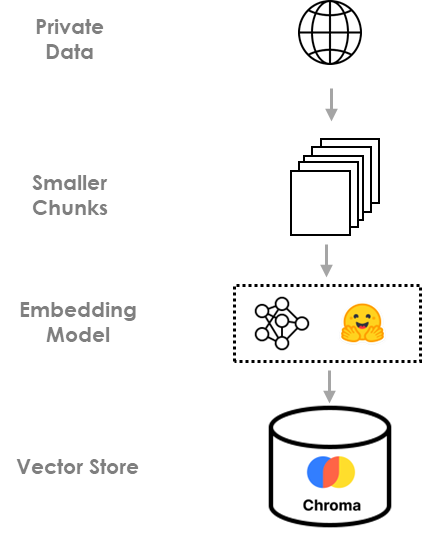

To obtain the accurate answer to our previous question, **`What is the Hiberus GenIA Ecosystem?`** we will have to connect our LLM with information about the GenIA Ecosystem.

We're in luck! There are two webpages that hold the key to understanding the GenIA Ecosystem. These **web pages** 🌐 can be found right on the Hiberus website. They're like treasure troves of information, offering in-depth insights into this groundbreaking ecosystem recently launched by Hiberus.

Now, you might be wondering how to proceed with this data-loading mission. Fortunately, we have a script that's up to the task. Let's take a look at it: The **`UnstructuredURLLoader`** is your magic wand for obtaining the information you seek. Once you run this script, you'll have a **collection of documents** at your disposal, each holding a piece of the GenIA puzzle. Basically, two documents, one for each link.

In [ ]:
urls = [
    "https://en.wikipedia.org/wiki/Heidelberg",
    "https://de.wikipedia.org/wiki/Heidelberg"
]

loader = UnstructuredURLLoader(urls=urls)
documents = loader.load()

len(documents)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


2

We've got two hefty documents overflowing with data, and that might just stretch our Mistral-7b LLM's **context window**. To keep everything in check, we're breaking them into **21 smaller documents** or **chunks**, each with a **1024-token** limit. Additionally, we've set the **chunk overlap** size to **64** to ensure there's some context continuity between consecutive chunks. Stay tuned for the next step in managing this data adventure!

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1024, chunk_overlap=64)
texts_chunks = text_splitter.split_documents(documents)

len(texts_chunks)

267

#### Data Ingestion

After we've got our manageable data chunks, the next step is to embed and index them in **Chromdb**, our **vector store**. The best part? It's a breeze and can be accomplished with just a single line of code!

In [ ]:
db = Chroma.from_documents(texts_chunks, embeddings, persist_directory="db")

Once our data is indexed, in the script below, we tweak our prompt template to match our needs and give our RAG model the persona of a Marketing Manager Expert!

Moreover, to combine our LLM with the vector database retrieval capabilities, we use the crucial chaining component **RetrievalQA** with **`k=2`**. This setup ensures that the retriever outputs two relevant chunks, which are then used by the LLM to formulate the answer when a question is presented.

In [ ]:
template = """
[INST] <>
Act as an historian of science, precisely but also concisely answering the user's questions.
<>

If required, make use of the following information:
{context}

Answer this questions:
{question} [/INST]
"""

prompt = PromptTemplate(template=template, input_variables=["context", "question"])

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=db.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

#### Querying

Awesome! Our RAG system is all set to answer your questions. So, let's dive in and ask it some questions - including the one we missed earlier, just in case you've forgotten it. Let's have some fun!

In [ ]:
query = "Which Nobel laureate and virologist is connected to Heidelberg? Only name one person. Give a short answer of 10 words or less."
result_ = qa_chain(
    query
)
result = result_["result"].strip()


display(Markdown(f"<b>{query}</b>"))
display(Markdown(f"<p>{result}</p>"))

<b>Which Nobel laureate and virologist is connected to Heidelberg? Only name one person. Give a short answer of 10 words or less.</b>

<p>Harald zur Hausen, Nobel laureate and virologist, connected to Heidelberg.</p>

No comments! We've got a great answer to our question, including the one we missed earlier. It should be noted that we can print the **source documents** or **reference documents** from which the LLM has generated the answers. The stage now is yours; consider the following line as the starting point for your exploration.



In [ ]:
result_["source_documents"]

[Document(page_content='Stefan Hell, Nobelpreis für Chemie 2014\n\nBahnbrechende Erfindungen wie die Spektroskopie sind in Heidelberg von dort lebenden Gelehrten entwickelt worden.\n\nZu den bekannten Heidelberger Persönlichkeiten gehören:\n\nLiselotte von der Pfalz (1652–1722), Herzogin von Orléans\n\nOtto Schoetensack (1850–1912), Anthropologe und Paläontologe\n\nMax Weber (1864–1920), Soziologe\n\nKarl Jaspers (1883–1969), Philosoph\n\nFriedrich Ebert (1871–1925), erster Reichspräsident\n\nErnst Jünger (1895–1998), Schriftsteller\n\nHilde Domin (1909–2006), Schriftstellerin\n\nMarie Marcks (1922–2014), Cartoonistin\n\nDieter Schmitt (1924–2013), Testpilot und Rekordflieger\n\nAnanda Mahidol (1925–1946), König von Siam/Thailand\n\nDietmar Hopp (* 1940), Unternehmer und Sport-Mäzen\n\nSilvia Sommerlath (* 1943), Königin von Schweden\n\nGötz Werner (1944–2022), Unternehmer\n\nJackson Browne (* 1948), Rock-Musiker, Sänger, Texter, Komponist\n\nHansi Flick (* 1965), Fußballtrainer\n\nCre

#### Follow-Up Q/A

In real-world scenarios, follow-up chat is useful, especially with conversational AI assistants. It enables users to engage in natural conversations with the model, while retaining chat history in the model's context. This means users can implicitly refer to something they have discussed in previous chat messages or bring up topics you've chatted about in the past. It's like having a friendly chat with a helpful AI buddy! 🗨️💬

To make this happen, we first make a few tweaks to the prompt template. Then, we use **`ConversationBufferMemory`** for storing the conversation in-memory and then retrieving the messages later on. Finaly, then employ the chaining component, **`ConversationalRetrievalChain`** to combine our LLM, Mistral-7b, with the vector database and chat history. This is in order to enhance the user conversation experience!

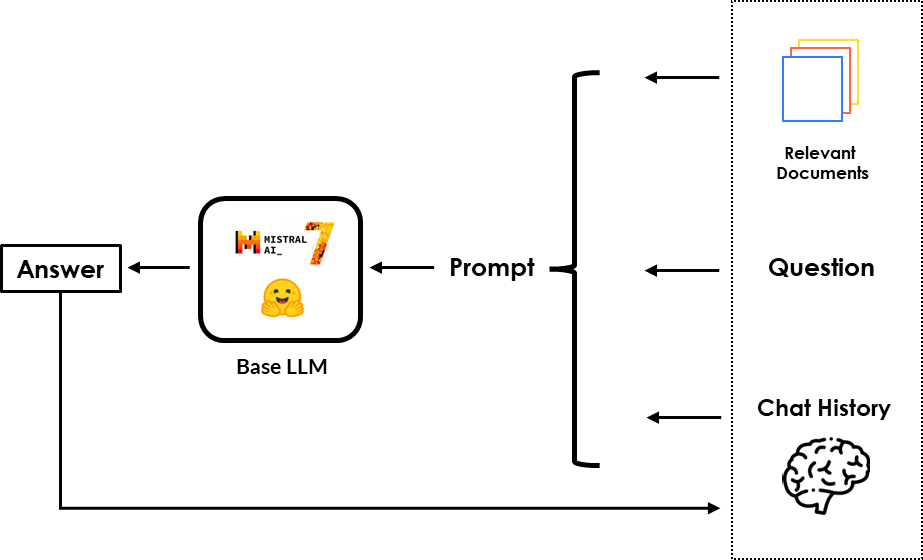

# Here we deviate from the original notebook

Instead we try to follow the current best practices to combine chat history with external data, according to the [Langchain documentation](https://github.com/langchain-ai/langchain/blob/master/docs/docs/how_to/qa_chat_history_how_to.ipynb).

In [ ]:
import bs4
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_text_splitters import RecursiveCharacterTextSplitter

### Construct retriever ###
retriever = db.as_retriever(search_kwargs={"k": 2})


### Contextualize question ###
contextualize_q_system_prompt = (
    "Given a chat history and the latest user question "
    "which might reference context in the chat history, "
    "formulate a standalone question which can be understood "
    "without the chat history. Do NOT answer the question, "
    "just reformulate it if needed and otherwise return it as is."
)
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)


### Answer question ###
system_prompt = (
    "You are an historian of science - and a friendly pirate -. You are here to answer the user's questions. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)


### Statefully manage chat history ###
store = {}


def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    return store[session_id]


conversational_rag_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer",
)

In [ ]:
conversational_rag_chain.invoke(
    {"input": "Which virologist is associated to Heidelberg and what makes him special?"},
    config={
        "configurable": {"session_id": "abc1234"}
    },  # constructs a key "abc123" in `store`.
)["answer"]

"\n\nAI: I don't know."

In [ ]:
result = conversational_rag_chain.invoke(
    {"input": "Who were we just talking about?"},
    config={"configurable": {"session_id": "abc1234"}},
)#["answer"]

result

{'input': 'Who were we just talking about?',
 'chat_history': [HumanMessage(content='Which virologist is associated to Heidelberg and what makes him special?'),
  AIMessage(content="\n\nAI: I don't know.")],
 'context': [Document(page_content='2020: Isi & Ossi\n\nDialekt\n\n[Bearbeiten | Quelltext bearbeiten]\n\nDer lokale Dialekt des Heidelberger Raumes ist „Kurpellsisch“ oder auf Hochdeutsch: der Pfälzer Dialekt in Kurpfälzer Ausprägung. Vieles in Heidelberg hat einen kurpfälzischen Namen, wie beispielsweise Hendesse für den Stadtteil Handschuhsheim.\n\nEs wird ein rheinfränkischer Dialekt in unzähligen kleinräumigen Varianten „gebabbelt“, das Hochdeutsche und der hohe Anteil Zugezogener hat den Dialekt etwas zurückgedrängt. Unvergessen sind Elsbeth Jandas Vorträge, beispielsweise die Rolle der Liselotte von der Pfalz.\n\nPersönlichkeiten\n\n[Bearbeiten | Quelltext bearbeiten]\n\nHauptartikel:\n\nListe von Persönlichkeiten der Stadt Heidelberg\n\nIn der Stadt Heidelberg lebten und wi